In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# from plot_config import graph

In [2]:
model_filter = {
    'FacEval': ['bart_large', 'co-ref bart large', 'condigsum bart large','gpt4-32k-0613','mv-bart_large', 'alpaca-13b'],
    'SAMSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b'],
    'DialogueSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b']

}
def read_filter(filename):
    df = pd.read_csv(filename)
    df_datasets = []
    unique_datasets = list(set(df['origin'].values))
    for dataset in unique_datasets: 
        df_origin = df[df['origin'] == dataset]
        df_origin = df_origin[df_origin['model'].isin(model_filter[dataset])]
        # print(len(df_origin))
        unique_docids = list(set(df_origin['docid'].values))
        #### test ###
        num_models = []
        for udocid in unique_docids:
            df_docid = df_origin[df_origin['docid'] == udocid]
            num_models.append(len(list(set(df_docid['model'].values))))
        # print(df_docid)
        # assert(len(set(num_models)) == 1) 
        df_datasets.append(df_origin)
    df_filtered = pd.concat(df_datasets)
    assert(len(df_filtered) <= len(df))
    return df_filtered

In [3]:
def text_consistent(response):
    inconsistent_phrases = ['no inconsisten', 'none', '[]', 'is consistent']
    if not response.strip():
        return True
    
    elif [each  for each in inconsistent_phrases if each in response.lower()]:
        return True
    return False

In [4]:
pd.read_csv('/home/ramprasad.sa/factual_evaluation_source_based/datasets/scored/predict_entailment_label_zeroshot.csv')



,Unnamed: 0.1,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,factual_error,error_type,dialogue,origin,dialogue_atomic_facts,response_ent1_Afact_GPT_zeroshot,labels_ent1_Afact_GPT_zeroshot,response_ent1_Dlg_GPT_zeroshot,labels_ent1_Dlg_GPT_zeroshot
0,0,0,test_312,CODS,[],[],#Person1# asks #Person2# to go to China with #...,0,[],#Person1#: I want to go to china for sight-see...,DialogueSum,Person1 wants to go to China.\nThe purpose of ...,Yes,0,Yes,0
1,1,1,test_312,UniLM,[],[],person1 wants to go to china for sight - seein...,0,[],#Person1#: I want to go to china for sight-see...,DialogueSum,Person1 wants to go to China.\nThe purpose of ...,Yes,0,Yes,0
2,2,2,test_312,BART,[],[],##Person1# wants to go to China but #Person2#'...,0,[],#Person1#: I want to go to china for sight-see...,DialogueSum,Person1 wants to go to China.\nThe purpose of ...,Yes,0,Yes,0
3,3,3,test_312,MV-BART,[],[],#Person1# wants to go to China for sight-seein...,0,[],#Person1#: I want to go to china for sight-see...,DialogueSum,Person1 wants to go to China.\nThe purpose of ...,Yes,0,Yes,0
4,4,4,test_312,gpt4-32k-0613,[],[],Person1 expresses a desire to visit China for ...,0,[],#Person1#: I want to go to china for sight-see...,DialogueSum,Person1 wants to go to China.\nThe purpose of ...,Yes,0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029,2029,2029,13730730,mv-bart_large,[],[],Annie will drop Theraflu sachets through Chris...,0,[],Annie: Are you going to be at school?\nChristi...,FacEval,Annie asks Christine if she is going to be at ...,Yes,0,Yes,0
2030,2030,2030,13730730,co-ref bart large,[],[],Christine is not going to school tomorrow. She...,0,[],Annie: Are you going to be at school?\nChristi...,FacEval,Annie asks Christine if she is going to be at ...,Yes,0,Yes,0
2031,2031,2031,13730730,bart_large,[],[],Christine is not going to school tomorrow beca...,0,[],Annie: Are you going to be at school?\nChristi...,FacEval,Annie asks Christine if she is going to be at ...,Yes,0,Yes,0
2032,2032,2032,13730730,gpt4-32k-0613,[],[],Christine informs Annie that she won''t be att...,0,[],Annie: Are you going to be at school?\r\nChris...,FacEval,Annie asks Christine if she is going to be at ...,Yes,0,Yes,0


In [15]:
span_path = 'factual_evaluation_source_based/datasets/scored/gen_nonfactual_spans.csv'

df_span = pd.read_csv(f'/home/ramprasad.sa/{span_path}')
for key in df_span.keys():
    if 'response' in key:
        spans = list(df_span[key].values)
        # labels = [eval(each) for each in labels]
        labels = [0 if text_consistent(each) else 1 for each in spans]
        
        label_key = '_'.join(key.split('instr')[1:])
        label_key = f'label_span{label_key}'
        # print(label_key)
        df_span[label_key] = labels


In [20]:
set(df_span['origin'].values)

{'DialogueSum', 'FacEval', 'SAMSum'}

In [21]:
# filepath = 'xformer_llm_annotated_scored.csv'
def get_keep_indices(fewshot_files):
    all_indices = []
    for fewshot_file in fewshot_files:
        all_indices += list(fewshot_file['Unnamed: 0'].values)
    keep_indices = [each for each in set(all_indices) if all_indices.count(each) == len(fewshot_files)]
    return keep_indices

global_path = '/home/ramprasad.sa/factual_evaluation_source_based/datasets/scored'

shot_files = [read_filter(f'{global_path}/predict_nonfactual_label_fewshot.csv').sort_values('Unnamed: 0'),
              read_filter(f'{global_path}/predict_nonfactual_label_zeroshot.csv').sort_values('Unnamed: 0'),
               df_span.sort_values('Unnamed: 0')]
            # read_filter(f'{global_path}/predict_entailment_label_zeroshot.csv').sort_values('Unnamed: 0')


keep_indices = get_keep_indices(shot_files)

standard_metric_file = read_filter(f'{global_path}/baseline_metrics_qafact.csv').sort_values('Unnamed: 0')
standard_metric_file = standard_metric_file[standard_metric_file['Unnamed: 0'].isin(keep_indices)]
zeroshot_file = read_filter(f'{global_path}/baseline_metrics.csv').sort_values('Unnamed: 0')
# fewsot_file = 

for fidx, file in enumerate(shot_files + [zeroshot_file]):
    file = file[file['Unnamed: 0'].isin(keep_indices)]
    assert(list(standard_metric_file['summary'].values) == list(file['summary'].values))
    for key in file.keys():
        # print(key)
        if [each in key for each in ['QuestEval', 'SummaC', 'Alpaca', 'GPT']]:
            column_key = key
            if column_key not in standard_metric_file.keys():
                standard_metric_file[column_key] = list(file[key].values)
            # else:
            #     print("ERROR", key)

In [22]:
aggregate_df = standard_metric_file
# list(aggregate_df.keys())

In [26]:
set(aggregate_df['origin'].values)

{'DialogueSum', 'FacEval', 'SAMSum'}

In [27]:
def calculate_auc_score(predictions, labels):
    score = roc_auc_score(labels, predictions)
    return score


In [28]:

def get_metric_name_prompt(column_name):
    column_words = column_name.split('_')
    if 'zero' in column_words[-1]:
        shot_str = '0-shot'
    else:
        shot_str = '2-shot'
    if 'span' in column_name:
        metric_name = f'{column_words[-2]}-Span ({shot_str})'
    elif 'ent' in column_name: 
        metric_name = f'{column_words[-2]}-Ent ({shot_str})'
    else:
        metric_name = f'{column_words[-2]}-DA ({shot_str})'
    return metric_name

def get_metric_name_standard(column_name):
    metric_name = column_name.split('_')[0]
    metric_name = metric_name.strip('-Afacts')
    return metric_name
    
def get_prompt_performance(df, metric_scores):
    shot_scores = {}
    for column_name in df.keys():
        if 'shot' in column_name and 'label' in column_name:
            # print(column_name)
            if 'Afact' in column_name:
                source_type = 'Atomic Facts'
            else:
                source_type = 'Dialogue'
            base_str = get_metric_name_prompt(column_name)
            shot_score_name = f'{base_str}-{source_type}'
            # print(shot_score_name)
            predictions = list(df[column_name].values)
            labels = list(df['factual_error'].values)
            labels_flipped = [1 - each for each in labels]
            
            column_auc = max([calculate_auc_score(predictions, labels), calculate_auc_score(predictions, labels_flipped)])
            
            
            if shot_score_name not in shot_scores:
                shot_scores[shot_score_name] = []
            shot_scores[shot_score_name].append(column_auc)
    # print(shot_scores)
    for shot_name, shot_instr_scores in shot_scores.items():
            metric_name_str = '-'.join(shot_name.split('-')[:-1])
            source_type = shot_name.split('-')[-1]
            if metric_name_str not in metric_scores:
                metric_scores[metric_name_str] = {'Dialogue': [], 'Atomic Facts': []}
            metric_scores[metric_name_str][source_type] += [max(shot_instr_scores)]
        
    return metric_scores


def get_standard_performance(df, metric_scores):
    for column_name in df.keys():
        if 'score' in column_name:
            if 'Afact' in column_name:
                source_type = 'Atomic Facts'
            else:
                source_type = 'Dialogue'
            metric_name = get_metric_name_standard(column_name)
            
            predictions = list(df[column_name].values)
            labels = list(df['factual_error'].values)
            labels_flipped = [1 - each for each in labels]
            column_auc = max([calculate_auc_score(predictions, labels), calculate_auc_score(predictions, labels_flipped)])
            if metric_name not in metric_scores:
                metric_scores[metric_name] = {'Dialogue': [], 'Atomic Facts': []}
            metric_scores[metric_name][source_type] += [column_auc]
    return metric_scores

def make_df_perf(metric_scores, prompt_metrics = False):
    df_scores = {
        'metric_name': [],
        'Dialogue': [],
        'Atomic Facts': []
    }
    
    metric_sorted = ['SummaC-ZS', 'SummaC-conv', 'QuestEval', 'QAFactEval', 
                 'Alpaca-DA (0-shot)', 'Alpaca-DA (2-shot)','Alpaca-Span (0-shot)', 'Alpaca-Span (2-shot)',
                 'GPT-DA (0-shot)', 'GPT-DA (2-shot)',
                    'GPT-Span (0-shot)', 'GPT-Span (2-shot)',
                    ]
    if not prompt_metrics:
        metric_sorted = [each for each in metric_sorted if 'shot' not in each]
    else:
        metric_sorted = [each for each in metric_sorted if 'shot' in each]
    '''Comment if you want Alpaca performance'''
    metric_sorted = [each for each in metric_sorted if 'Alpaca' not in each]
    
    print(metric_scores.keys())
    for metric_name in metric_sorted:
        metric_name_info =  metric_scores[metric_name]
        df_scores['metric_name'].append(metric_name)
        for src_type, src_score in metric_name_info.items():
            df_scores[src_type].append(src_score[0])
    return pd.DataFrame(df_scores)
def update_metrics_performance(df, prompt_metrics = True):
    
    llm_models = ['gpt4-32k-0613', 'alpaca-13b']
    df_llm = aggregate_df[aggregate_df['model'].isin(llm_models)]
    df_xformer = aggregate_df[~aggregate_df['model'].isin(llm_models)]
    
    if prompt_metrics:
        metric_scores_llm = get_prompt_performance(df_llm, {})
    else:
        metric_scores_llm = get_standard_performance(df_llm, {})
    metric_scores_llm = make_df_perf(metric_scores_llm, prompt_metrics)

    if prompt_metrics:
        metric_scores_xformer = get_prompt_performance(df_xformer, {})
    else:
        metric_scores_xformer = get_standard_performance(df_xformer, {})
    metric_scores_xformer = make_df_perf(metric_scores_xformer, prompt_metrics)

    metric_scores_llm = metric_scores_llm.set_index(['metric_name'])
    metric_scores_xformer = metric_scores_xformer.set_index(['metric_name'])
    
    return metric_scores_llm, metric_scores_xformer
    
  
metric_scores_llm, metric_scores_xformer = update_metrics_performance(aggregate_df, prompt_metrics = False)
metric_scores_llm_prompt, metric_scores_xformer_prompt = update_metrics_performance(aggregate_df, prompt_metrics = True)


dict_keys(['QAFactEval', 'SummaC-ZS', 'SummaC-conv', 'QuestEval'])
dict_keys(['QAFactEval', 'SummaC-ZS', 'SummaC-conv', 'QuestEval'])
dict_keys(['Alpaca-DA (2-shot)', 'GPT-DA (2-shot)', 'Alpaca-DA (0-shot)', 'GPT-DA (0-shot)', 'Alpaca-Span (0-shot)', 'Alpaca-Span (2-shot)', 'GPT-Span (0-shot)', 'GPT-Span (2-shot)'])
dict_keys(['Alpaca-DA (2-shot)', 'GPT-DA (2-shot)', 'Alpaca-DA (0-shot)', 'GPT-DA (0-shot)', 'Alpaca-Span (0-shot)', 'Alpaca-Span (2-shot)', 'GPT-Span (0-shot)', 'GPT-Span (2-shot)'])


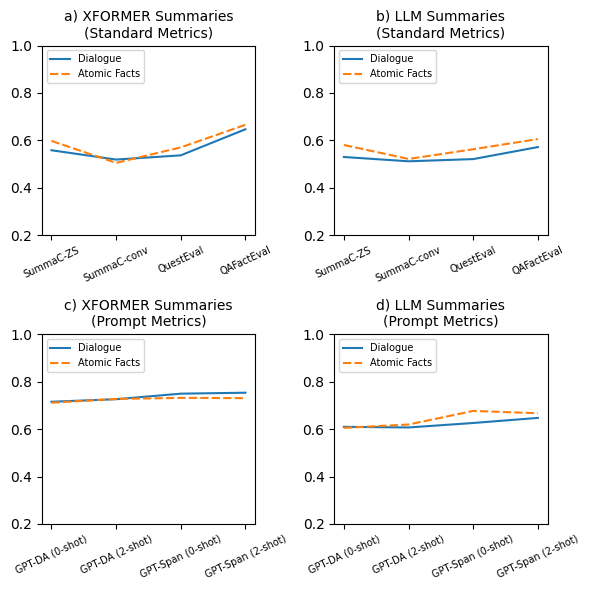

In [29]:
import seaborn as sns
fig, axs = plt.subplots(2,2, figsize = (6,6))
all_metric_dfs = [metric_scores_xformer, metric_scores_llm, metric_scores_xformer_prompt, metric_scores_llm_prompt]
titles = ['a) XFORMER Summaries\n(Standard Metrics)', 'b) LLM Summaries\n(Standard Metrics)', 'c) XFORMER Summaries\n(Prompt Metrics)', 'd) LLM Summaries\n(Prompt Metrics)']
xlabels = ['Standard Metrics', 'Standard Metrics', 'Prompt Metrics', 'Prompt Metrics']
ax_ids = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
for idx, metric_df in enumerate(all_metric_dfs):
    sns.lineplot(data=metric_df ,ax = ax_ids[idx])
    ax_ids[idx].tick_params(axis='x', rotation=25, labelsize = 7)
    ax_ids[idx].set_title(titles[idx], fontsize = 10)
    ax_ids[idx].set_xlabel('', fontsize = 8)     
    ax_ids[idx].legend(loc=2, prop={'size': 7})
    plt.setp(axs, ylim=(0.2, 1))
    plt.tight_layout()

# sns.lineplot(data=metric_scores_llm,ax = axs[1])
# axs[1].tick_params(axis='x', rotation=85)
# axs[1].set_title('LLM')
# axs[1].set_xlabel('Metrics')  
# plt.setp(axs, ylim=(0.0,1.0))

plt.tight_layout()
plt.savefig('label_performance_xformer_vs_llm.pdf')

In [30]:
set(aggregate_df['origin'].values)

{'DialogueSum', 'FacEval', 'SAMSum'}

In [132]:
import numpy as np
import seaborn as sns

def make_threshold_plots(metric_threshold_map_all_models):
    #'SummaC-ZS-Afacts_score', 'SummaC-conv-Afacts_score' 'QuestEval-Afacts_score'QAFactEval-Afact_scores
    metric_groups = [
        'SummaC-ZS', 
        'SummaC-conv', 
        'QuestEval',
        'QAFactEval']
        # 'SummaC-ZS(AF)', 
        # 'SummaC-conv(AF)', 
        # 'QuestEval(AF)', 
        # 'QAFactEval(AF)']

    datasets = ['RefMatters (DialogSum)', 'RefMatters (SAMSum)', 'FacEval (SAMSum)']
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
    fig.suptitle('Thresholds for metrics on dialogue and atomic facts as input.')
    plot_list = []
    col_idx = 0
    for row_idx, group in enumerate(metric_groups):
        df_group = metric_threshold_map_all_models[metric_threshold_map_all_models['metric'] == group]
        print(df_group['dataset'].values, df_group['metric'].values)
        plot_group = sns.scatterplot(data=df_group, 
                            x="dataset", 
                            y="threshold", 
                            hue = 'model', 
                            palette = sns.color_palette('tab10'),
                            ax=axs[row_idx])
        axs[row_idx,].set_title(group)
        axs[row_idx,].tick_params(axis='x', rotation=5)
        axs[row_idx].set_ylim(-1, 4)
        axs[row_idx].get_legend().set_visible(False)
    
    lines, labels = axs[row_idx].get_legend_handles_labels()
    
    fig.legend(lines, labels, loc="lower right")
    fig.tight_layout()
    fig.savefig("threshold_plots.pdf", bbox_inches='tight')
    plt.show()
    return
    

def get_threshold(df, metric_threshold_map, metric_threshold_dict, model_type, dataset_info):
    metrics = ['SummaC-ZS_score', 'SummaC-conv_score', 'QuestEval_score',\
               'SummaC-ZS-Afacts_score', 'SummaC-conv-Afacts_score',\
               'QuestEval-Afacts_score', 'QAFactEval_scores',\
               'QAFactEval-Afacts_scores']

    # metric_threshold_dict = {}

    for metric in metrics:
        # print(metric)
        metric_scores = list(df[metric].values)
        metric_threshold = np.mean(metric_scores)
        
        metric_name = metric.split('_score')[0].strip()
        if 'Afact' in metric_name:
            metric_name = metric_name.split('-Afacts')[0].strip()
            metric_name = metric_name.split('-Afact')[0].strip()
            metric_name = f'{metric_name}(AF)'
        metric_threshold_map['metric'].append(metric_name)
        metric_threshold_map['model'].append(model_type)
        metric_threshold_map['threshold'].append(metric_threshold)
        metric_threshold_map['dataset'].append(dataset_info[-1])

        if model_type not in metric_threshold_dict:
            metric_threshold_dict[model_type] = {}
        if dataset_info[0] not in metric_threshold_dict[model_type]:
            metric_threshold_dict[model_type][dataset_info[0]] = {}
        
        metric_threshold_dict[model_type][dataset_info[0]][metric] = metric_threshold
        
    return metric_threshold_map, metric_threshold_dict
    
    
def make_threshold_maps(df):
    metric_threshold_dict = {}
    
    metric_threshold_map_all_models = {
    'dataset': [],
    'metric': [],
    'model': [],
    'threshold': [],
    }
    
    llm_models = ['alpaca-13b', 'gpt4-32k-0613']
    df_llm = df[df['model'].isin(llm_models)]
    df_xformer = df[~df['model'].isin(llm_models)]

    # print(set(df_llm['origin'].values))
    dataset_names = list(set(df_llm['origin'].values))
    for dataset in dataset_names:
        if dataset == 'DialogueSum':
            dataset_str = f'RefMatters (DialogSum)'
        elif dataset == 'FacEval':
            dataset_str = f'FacEval (SAMSum)'
        elif dataset == 'SAMSum':
            dataset_str = f'RefMatters (SAMSum)'
        df_llm_dataset = df_llm[df_llm['origin'] == dataset]
        metric_threshold_map_all_models, metric_threshold_dict = get_threshold(df_llm_dataset, 
                                                        metric_threshold_map_all_models, 
                                                        metric_threshold_dict,
                                                        model_type = 'llm',
                                                        dataset_info = [dataset, dataset_str])
        df_xformer_dataset = df_xformer[df_xformer['origin'] == dataset]
        metric_threshold_map_all_models, metric_threshold_dict = get_threshold(df_xformer_dataset, 
                                                        metric_threshold_map_all_models, 
                                                        metric_threshold_dict,
                                                        model_type = 'xformer',
                                                        dataset_info = [dataset, dataset_str])
        # print(metric_threshold_dict)
    make_threshold_plots(pd.DataFrame(metric_threshold_map_all_models))
    return pd.DataFrame(metric_threshold_map_all_models), metric_threshold_dict




['RefMatters (DialogSum)' 'RefMatters (DialogSum)' 'FacEval (SAMSum)'
 'FacEval (SAMSum)' 'RefMatters (SAMSum)' 'RefMatters (SAMSum)'] ['SummaC-ZS' 'SummaC-ZS' 'SummaC-ZS' 'SummaC-ZS' 'SummaC-ZS' 'SummaC-ZS']
['RefMatters (DialogSum)' 'RefMatters (DialogSum)' 'FacEval (SAMSum)'
 'FacEval (SAMSum)' 'RefMatters (SAMSum)' 'RefMatters (SAMSum)'] ['SummaC-conv' 'SummaC-conv' 'SummaC-conv' 'SummaC-conv' 'SummaC-conv'
 'SummaC-conv']
['RefMatters (DialogSum)' 'RefMatters (DialogSum)' 'FacEval (SAMSum)'
 'FacEval (SAMSum)' 'RefMatters (SAMSum)' 'RefMatters (SAMSum)'] ['QuestEval' 'QuestEval' 'QuestEval' 'QuestEval' 'QuestEval' 'QuestEval']
['RefMatters (DialogSum)' 'RefMatters (DialogSum)' 'FacEval (SAMSum)'
 'FacEval (SAMSum)' 'RefMatters (SAMSum)' 'RefMatters (SAMSum)'] ['QAFactEval' 'QAFactEval' 'QAFactEval' 'QAFactEval' 'QAFactEval'
 'QAFactEval']


/tmp/ipykernel_9653/3264594365.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot_group = sns.scatterplot(data=df_group,
/tmp/ipykernel_9653/3264594365.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot_group = sns.scatterplot(data=df_group,
/tmp/ipykernel_9653/3264594365.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot_group = sns.scatterplot(data=df_group,
/tmp/ipykernel_9653/3264594365.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  plot_group = sns.scatterplot(data=df_group,


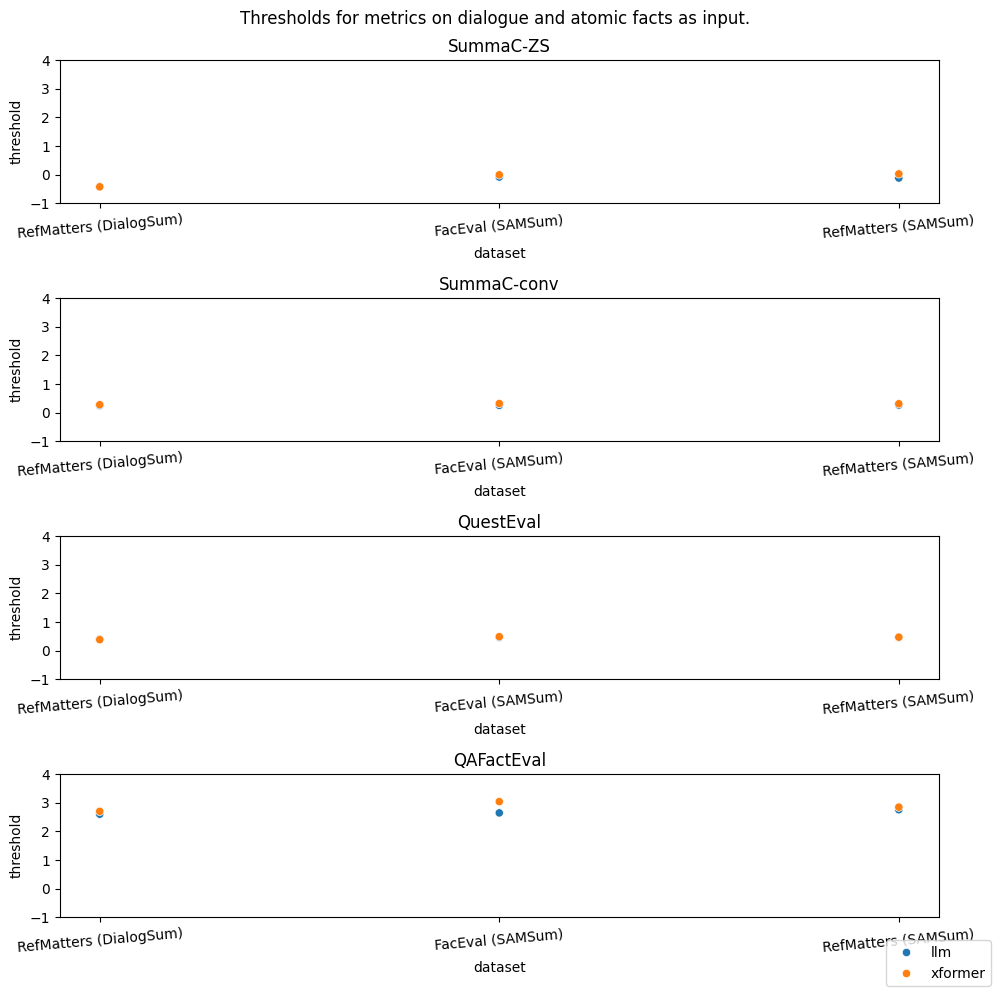

In [133]:
metric_threshold_map_all_models, metric_threshold_dict = make_threshold_maps(aggregate_df)

In [78]:
metric_threshold_map_all_models

,dataset,metric,model,threshold
0,RefMatters (DialogSum),SummaC-ZS,llm,-0.417741
1,RefMatters (DialogSum),SummaC-conv,llm,0.246921
2,RefMatters (DialogSum),QuestEval,llm,0.401481
3,RefMatters (DialogSum),SummaC-ZS(AF),llm,-0.387080
4,RefMatters (DialogSum),SummaC-conv(AF),llm,0.252496
5,RefMatters (DialogSum),QuestEval(AF),llm,0.431332
6,RefMatters (DialogSum),QAFactEval,llm,2.603180
7,RefMatters (DialogSum),QAFactEval(AF),llm,2.872158
8,RefMatters (DialogSum),SummaC-ZS,xformer,-0.426543
9,RefMatters (DialogSum),SummaC-conv,xformer,0.276773


In [73]:


def get_error_categ(error_type):
    intrinsic_found = 0
    extrinsic_found = 0
    # print(error_type)
    if 'Intrinsic_Error' in error_type:
        intrinsic_found = 1
    if 'Extrinsic_Error' in error_type:
        extrinsic_found = 1

    error_c = None
    if intrinsic_found:
        error_c = 'Intrinsic'
    if extrinsic_found:
        if error_c:
            error_c = 'Mixed'
        else:
            error_c = 'Extrinsic'
    # print(intrinsic_found, extrinsic_found)
    return error_c

def check_afact_membership(column):
    if '-afact' in column.lower():
        return True
    if '_afact' in column.lower():
        return True
    return False

def make_df_error_categ(df, model_type = None):
    df_errors = df[df['factual_error'] == 1]
    error_categ_counts = {
 
    }
    print(len(df_errors))
    for idx, row in df_errors.iterrows():
        error_type = eval(row['error_type'])
        error_c = get_error_categ(error_type)
        for column in row.keys():
            
            if 'label' in column or 'score' in column:
                
                metric_name = get_metric_name_prompt(column) if 'label' in column else get_metric_name_standard(column)
                row_pred_score = row[column]
                
                row_threshold = 0.5
                if 'score' in column:
                    row_threshold = metric_threshold_dict[model_type][column]
                pred_c = 1 if row_pred_score >= row_threshold else 0

                if metric_name not in error_categ_counts:
                    error_categ_counts[metric_name] = {}
                if error_c not in error_categ_counts[metric_name]:
                    error_categ_counts[metric_name][error_c] = []
                error_categ_counts[metric_name][error_c].append(pred_c)
    
    df_error_categ_counts = {
        'Metric': [],
        'Error_Cat':[],
        'Score': [],
        
        }
    all_metrics = ['SummaC-ZS', 'SummaC-conv', 'QuestEval', 'QAFactEval', 
                 'Alpaca-DA (0-shot)', 'Alpaca-DA (2-shot)','Alpaca-Span (0-shot)', 'Alpaca-Span (2-shot)',
                 'GPT-DA (0-shot)', 'GPT-DA (2-shot)',
                    'GPT-Span (0-shot)', 'GPT-Span (2-shot)']
    all_metrics = [each for each in all_metrics if 'Alpaca' not in each]
    # print(error_categ_counts.keys(), error_categ_counts['Alpaca-Span (fewshot)'])
    for metric_str in all_metrics:
            metric_categ_scores = error_categ_counts[metric_str]
            all_counts = 0
            for error_c in ['Intrinsic', 'Extrinsic', 'Mixed']:
                error_c_preds = metric_categ_scores[error_c]
                all_counts += len(error_c_preds)
                error_c_pred_score = error_c_preds.count(1)/len(error_c_preds)
                df_error_categ_counts['Metric'].append(metric_str)
                df_error_categ_counts['Error_Cat'].append(error_c)
                df_error_categ_counts['Score'].append(error_c_pred_score)
            print(metric_str, all_counts)
    return pd.DataFrame(df_error_categ_counts)

llm_models = ['gpt4-32k-0613', 'alpaca-13b']
df_llm = aggregate_df[aggregate_df['model'].isin(llm_models)]
df_xformer = aggregate_df[~aggregate_df['model'].isin(llm_models)]

df_error_categ_counts_xformer = make_df_error_categ(df_xformer, model_type = 'xformer')
# df_error_categ_counts_xformer_dlg = make_df_error_categ(df_xformer, False)
df_error_categ_counts_llm = make_df_error_categ(df_llm, model_type = 'llm')
# df_error_categ_counts_llm_dlg = make_df_error_categ(df_llm, False)

280
SummaC-ZS 560
SummaC-conv 560
QuestEval 560
QAFactEval 560
GPT-DA (0-shot) 1680
GPT-DA (2-shot) 1680
GPT-Span (0-shot) 1680
GPT-Span (2-shot) 1680
94
SummaC-ZS 188
SummaC-conv 188
QuestEval 188
QAFactEval 188
GPT-DA (0-shot) 564
GPT-DA (2-shot) 564
GPT-Span (0-shot) 564
GPT-Span (2-shot) 564


In [74]:
df_error_categ_counts_llm

,Metric,Error_Cat,Score
0,SummaC-ZS,Intrinsic,0.396552
1,SummaC-ZS,Extrinsic,0.515625
2,SummaC-ZS,Mixed,0.125000
3,SummaC-conv,Intrinsic,0.198276
4,SummaC-conv,Extrinsic,0.187500
5,SummaC-conv,Mixed,0.125000
6,QuestEval,Intrinsic,0.431034
7,QuestEval,Extrinsic,0.375000
8,QuestEval,Mixed,0.250000
9,QAFactEval,Intrinsic,0.465517


In [75]:
# df_error_categ_counts_xformer

0 0
XFORMER summaries
1 0
LLM summaries


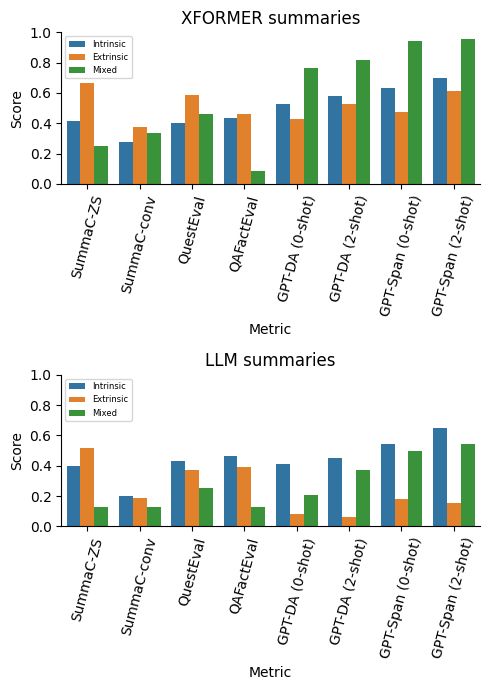

In [76]:
fig, axs = plt.subplots(2,1, figsize=(5,7), sharey=False)

def make_plot(df, xid, yid, title):
    print(title)
    # df =df.sort_values(['Error_Cat'])
    gfg = sns.barplot(data = df, 
                     x = 'Metric', 
                     y ='Score', 
                     hue = 'Error_Cat',
                    ax = axs[xid])
    
    gfg.legend(fontsize=6, loc = "upper left")
    axs[xid].tick_params(axis='x', rotation=75)
    axs[xid].set_title(title)
    axs[xid].set_ylim(0,1)
    axs[xid].spines[['right', 'top']].set_visible(False)
    plt.tight_layout()

dfs = [df_error_categ_counts_xformer, 
       df_error_categ_counts_llm,]
titles = [
    'XFORMER summaries',
    'LLM summaries',
]
#     'LLM summaries (Dialogues)',
#     'LLM summaries (Atomic Facts)'
# ]
idx = 0
for xid in range(0, 2):
    for yid in range(0, 1):
        print(xid, yid)
        df = dfs[idx]
        # print(df)
        make_plot(df, xid, yid, titles[idx])
        idx += 1
fig.tight_layout()
fig.savefig("error_category_plots.pdf", bbox_inches='tight')
plt.show()